##The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

##Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

1. Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? 

2. Explore the data using univariate and multivariate exploration techniques. 

3. In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

4. Summarize your findings. 

In [0]:
! pip install pandas-profiling
! pip install pandas-profiling==2.*

In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import pandas_profiling
import warnings
from fancyimpute import KNN
from scipy.stats import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
warnings.filterwarnings('ignore')

In [0]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)
engine.dispose()
life_df.columns = life_df.columns.str.strip()

In [4]:
life_df.shape

(2938, 22)

In [5]:
life_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


#Variables

1. Country - Country

2. Year - Year

3. Status - Developed or Developing

4. Life expectancy - Life Expectancy in age

5. Adult Mortality - Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)

6. infant deaths - Number of Infant Deaths per 1000 population

7. Alcohol - Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) percentage

8. percentage expenditure - Expenditure on health as a percentage of Gross Domestic Product per capita(%)

9. Hepatitis B - Hepatitis B (HepB) immunization coverage among 1-year-olds (%)

10. Measles Measles - number of reported cases per 1000 population

11. BMI - Average Body Mass Index of entire population

12. under-five deaths - Number of under-five deaths per 1000 population

13. Polio - Polio (Pol3) immunization coverage among 1-year-olds (%)

14. Total expenditure - General government expenditure on health as a percentage of total government expenditure (%)

15. Diphtheria - Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)

16. HIV/AIDS - Deaths per 1 000 live births HIV/AIDS (0-4 years)

17. GDP - Gross Domestic Product per capita (in USD)

18. Population - Population of the country

19. thinness 1-19 years - Prevalence of thinness among children and adolescents for Age 10 to 19 (% )

20. thinness 5-9 years - Prevalence of thinness among children for Age 5 to 9(%)

21. Income composition of resources - Human Development Index in terms of income composition of resources (index ranging from 0 to 1)

20. Schooling - Number of years of Schooling(years)

#Data cleaning

In [6]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [7]:
life_df.isnull().sum()*100/life_df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
BMI                                 1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
HIV/AIDS                            0.000000
GDP                                15.248468
Population                         22.191967
thinness  1-19 years                1.157250
thinness 5-9 years                  1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

In [0]:
#pandas_profiling.ProfileReport(life_df)

**Dealing with missing data. A lot of GDP and Population data is missing for some countries.**

**Due to the nature of the dataset, I can not use imputation with a mean or median strategy. If i use imputation, then I am taking information from other countries and putting it in for a different country.**

**for example, I will be taking population and GDP information from a different countries and imputing it as the population and GDP of a different countries. That information would be inaccurate.**

**I could meticoulously look up the information from the countries with missing data, but that would consume a lot of time.**

Drop rows with missing gdp and population information. That would leave me with 143 countries instead of 193 and 74% of the total data. By doing this, i will loose 26% of the data.

In [9]:
# get the mean baseline because this is a regression problem
# with regression, the baseline can be as simple as the mean.
print('Mean Baseline: {} years'. format(life_df['Life expectancy'].mean()),'\n')
print('Without any other factors, this is what we will predict the life expectancy to be')

Mean Baseline: 69.22493169398912 years 

Without any other factors, this is what we will predict the life expectancy to be


In [0]:
# drop gdp and population and life expectancy missing values
life_df = life_df.dropna(subset=['GDP', 'Population', 'Life expectancy'])

**Firstly, since we have year trends, we can interpolate missing valuse by grouping them by country.**

In [0]:
countries = life_df['Country'].unique()
#life_df.columns
#columns_list = ['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality','infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B','Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure','Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years','thinness 5-9 years', 'Income composition of resources', 'Schooling']
for country in countries:
    life_df.loc[life_df['Country'] == country,life_df.columns] = life_df.loc[life_df['Country'] == country,life_df.columns].interpolate()

In [12]:
life_df.isnull().sum()*100/life_df.isnull().count()

Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.000000
Adult Mortality                    0.000000
infant deaths                      0.000000
Alcohol                            6.366048
percentage expenditure             0.000000
Hepatitis B                        5.658709
Measles                            0.000000
BMI                                1.061008
under-five deaths                  0.000000
Polio                              0.000000
Total expenditure                  6.100796
Diphtheria                         0.000000
HIV/AIDS                           0.000000
GDP                                0.000000
Population                         0.000000
thinness  1-19 years               1.061008
thinness 5-9 years                 1.061008
Income composition of resources    0.000000
Schooling                          0.000000
dtype: float64

**The values missing now for countries where all values for a variable (for a specific country) were missing, so we will fill those values by imputer method using KNN**

In [0]:
life_df['Alcohol'] = KNN(k=3).fit_transform(life_df[['Alcohol']])
life_df['Hepatitis B'] = KNN(k=3).fit_transform(life_df[['Hepatitis B']])
life_df['BMI'] = KNN(k=3).fit_transform(life_df[['BMI']])
life_df['thinness  1-19 years'] = KNN(k=3).fit_transform(life_df[['thinness  1-19 years']])
life_df['thinness 5-9 years'] = KNN(k=3).fit_transform(life_df[['thinness 5-9 years']])

In [0]:
#pandas_profiling.ProfileReport(life_df)

**Now lets check the outliers**

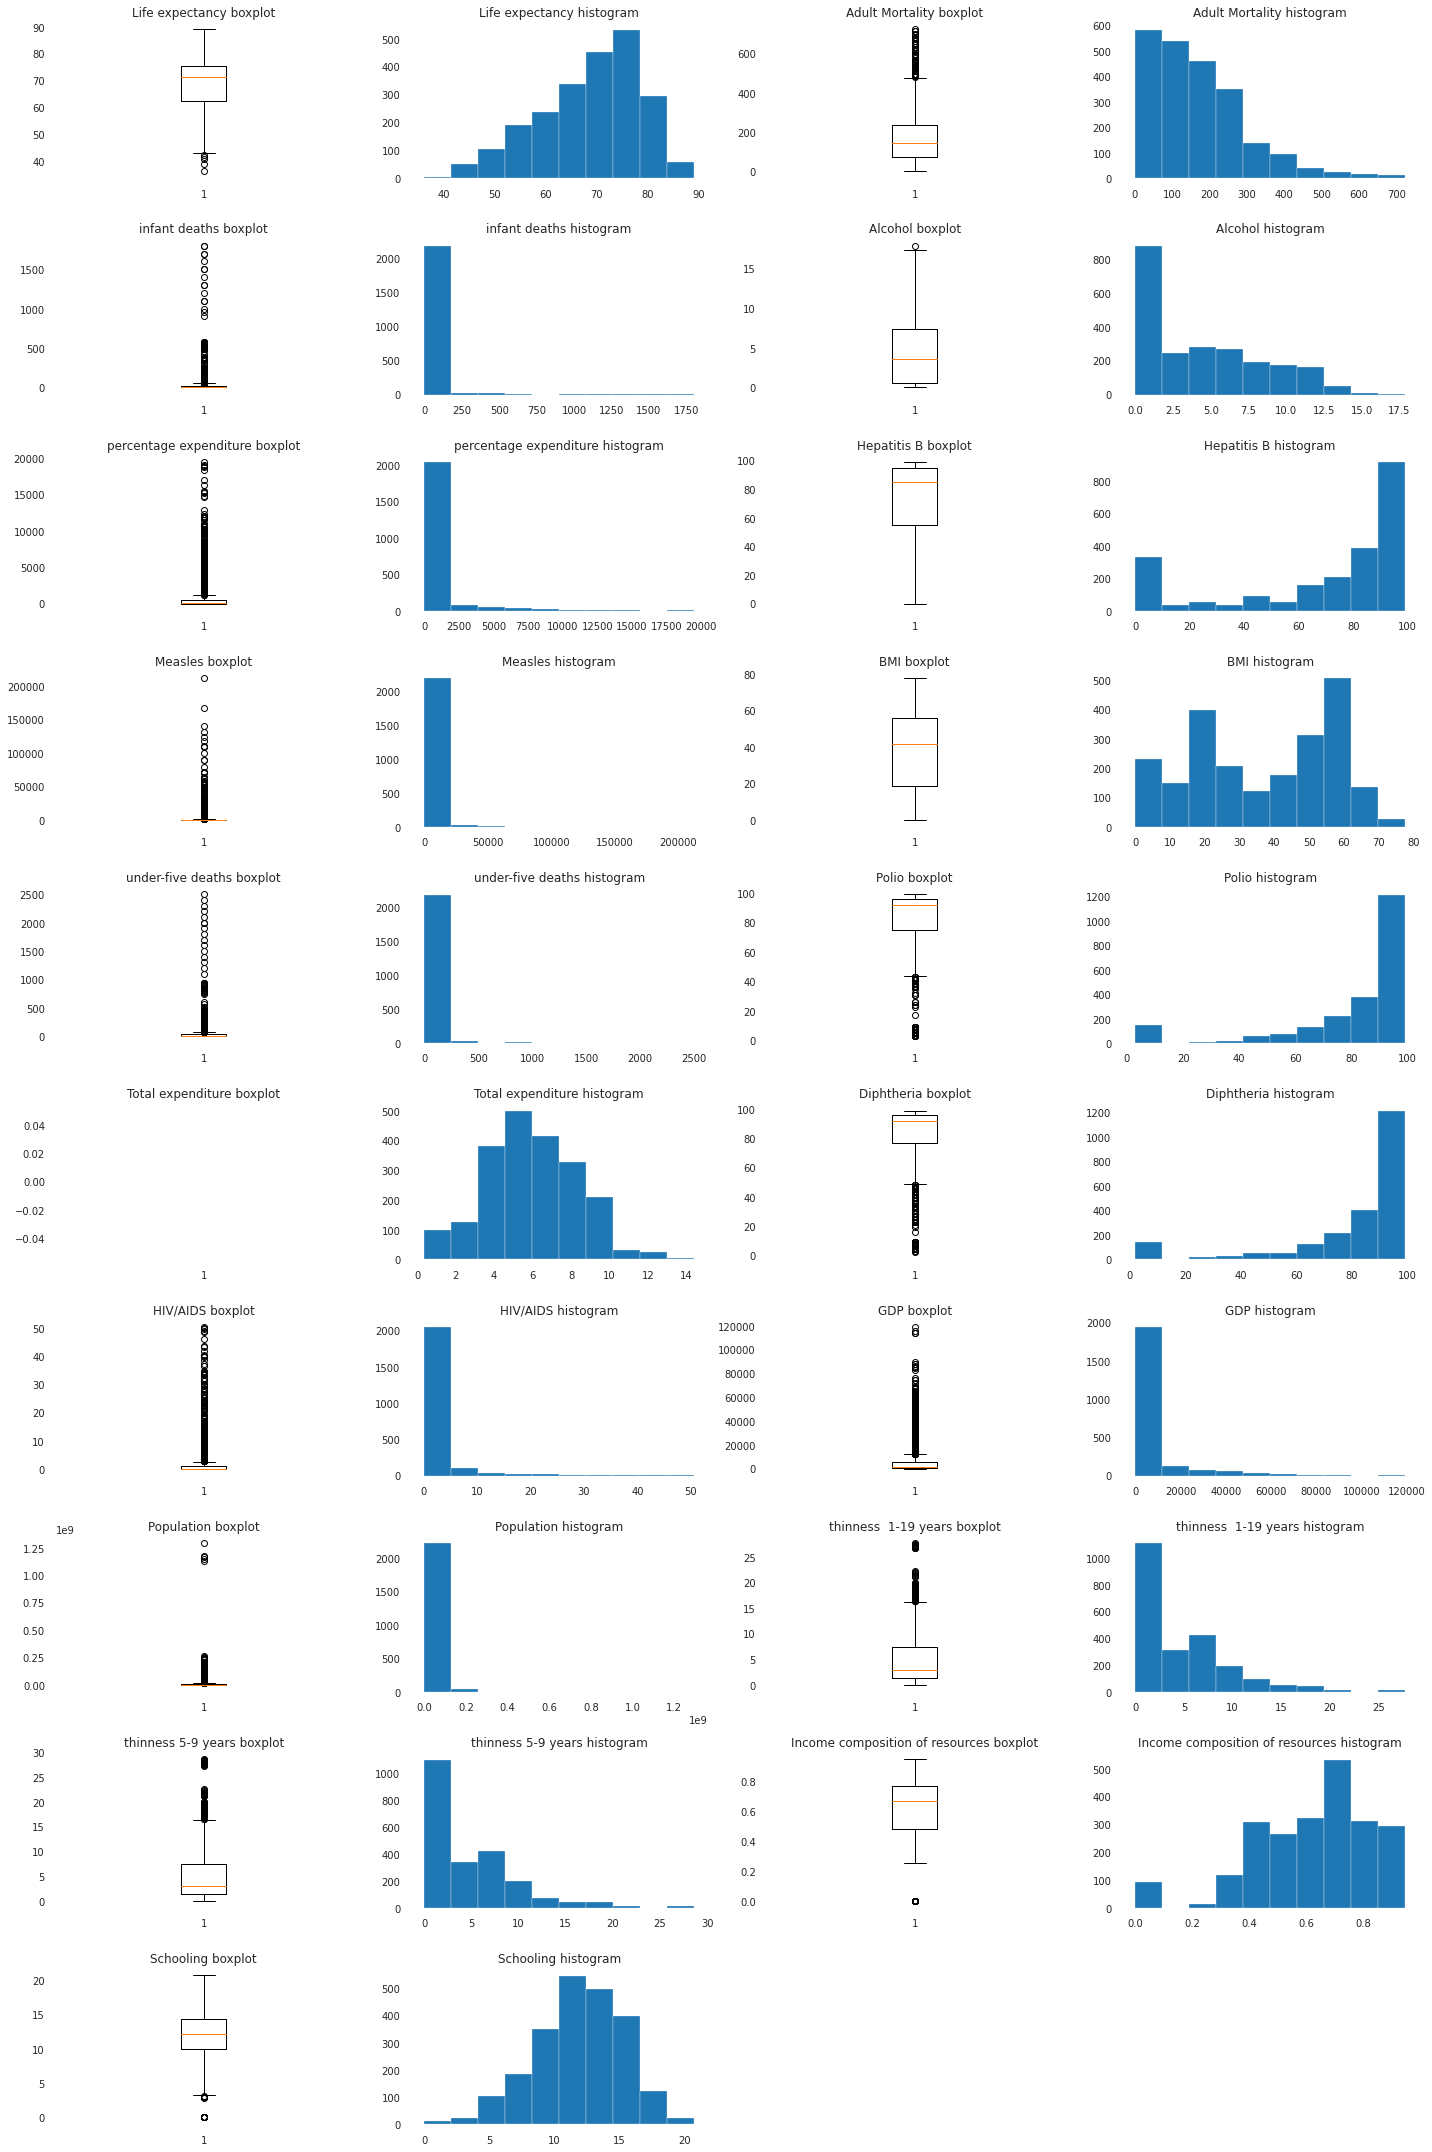

In [15]:
columns = ['Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling']
plt.figure(figsize=(20, 30))
i = 0
for column in columns:
    i += 1
    plt.subplot(10, 4, i)
    plt.tight_layout()
    plt.boxplot(life_df[column])
    plt.title('{} boxplot'.format(column))
    i += 1
    plt.subplot(10, 4, i )
    plt.tight_layout()
    plt.hist(life_df[column])
    plt.title('{} histogram'.format(column))
plt.show()

**Bxplot and Histogram for every numeric variable of the dataset before winsorizing the outlier.**

In [0]:
winsor_life_df = life_df.copy()

**Dealing with outliers using winsorize function (they will not be deleted in order not to lose important information)**

In [0]:
# We apply winsorization to the highest end of the value distribution. As we have a lot of extreme values
# Manually setted percentiles for every feature outside of which the outliers would be replaced.

winsor_life_df['Life expectancy'] = winsorize(winsor_life_df['Life expectancy'], (0.005, 0))
winsor_life_df['Adult Mortality'] = winsorize(winsor_life_df['Adult Mortality'], (0, 0.05))
winsor_life_df['infant deaths'] = winsorize(winsor_life_df['infant deaths'], (0, 0.11))
winsor_life_df['Alcohol'] = winsorize(winsor_life_df['Alcohol'], (0, 0.005))
winsor_life_df['percentage expenditure'] = winsorize(winsor_life_df['percentage expenditure'], (0, 0.13))
winsor_life_df['Measles'] = winsorize(winsor_life_df['Measles'], (0, 0.185))
winsor_life_df['under-five deaths'] = winsorize(winsor_life_df['under-five deaths'], (0, 0.1325))
winsor_life_df['Polio'] = winsorize(winsor_life_df['Polio'], (0.085, 0))
winsor_life_df['Total expenditure'] = winsorize(winsor_life_df['Total expenditure'], (0.0, 0.065))
winsor_life_df['Diphtheria'] = winsorize(winsor_life_df['Diphtheria'], (0.11, 0))
winsor_life_df['HIV/AIDS'] = winsorize(winsor_life_df['HIV/AIDS'], (0, 0.165))
winsor_life_df['GDP'] = winsorize(winsor_life_df['GDP'], (0, 0.138))
winsor_life_df['Population'] = winsorize(winsor_life_df['Population'], (0, 0.128))
winsor_life_df['thinness  1-19 years'] = winsorize(winsor_life_df['thinness  1-19 years'], (0, 0.035))
winsor_life_df['thinness 5-9 years'] = winsorize(winsor_life_df['thinness 5-9 years'], (0, 0.05))
winsor_life_df['Income composition of resources'] = winsorize(winsor_life_df['Income composition of resources'], (0.05, 0))
winsor_life_df['Schooling'] = winsorize(winsor_life_df['Schooling'], (0.008, 0))



**Outliers after winsorizing**

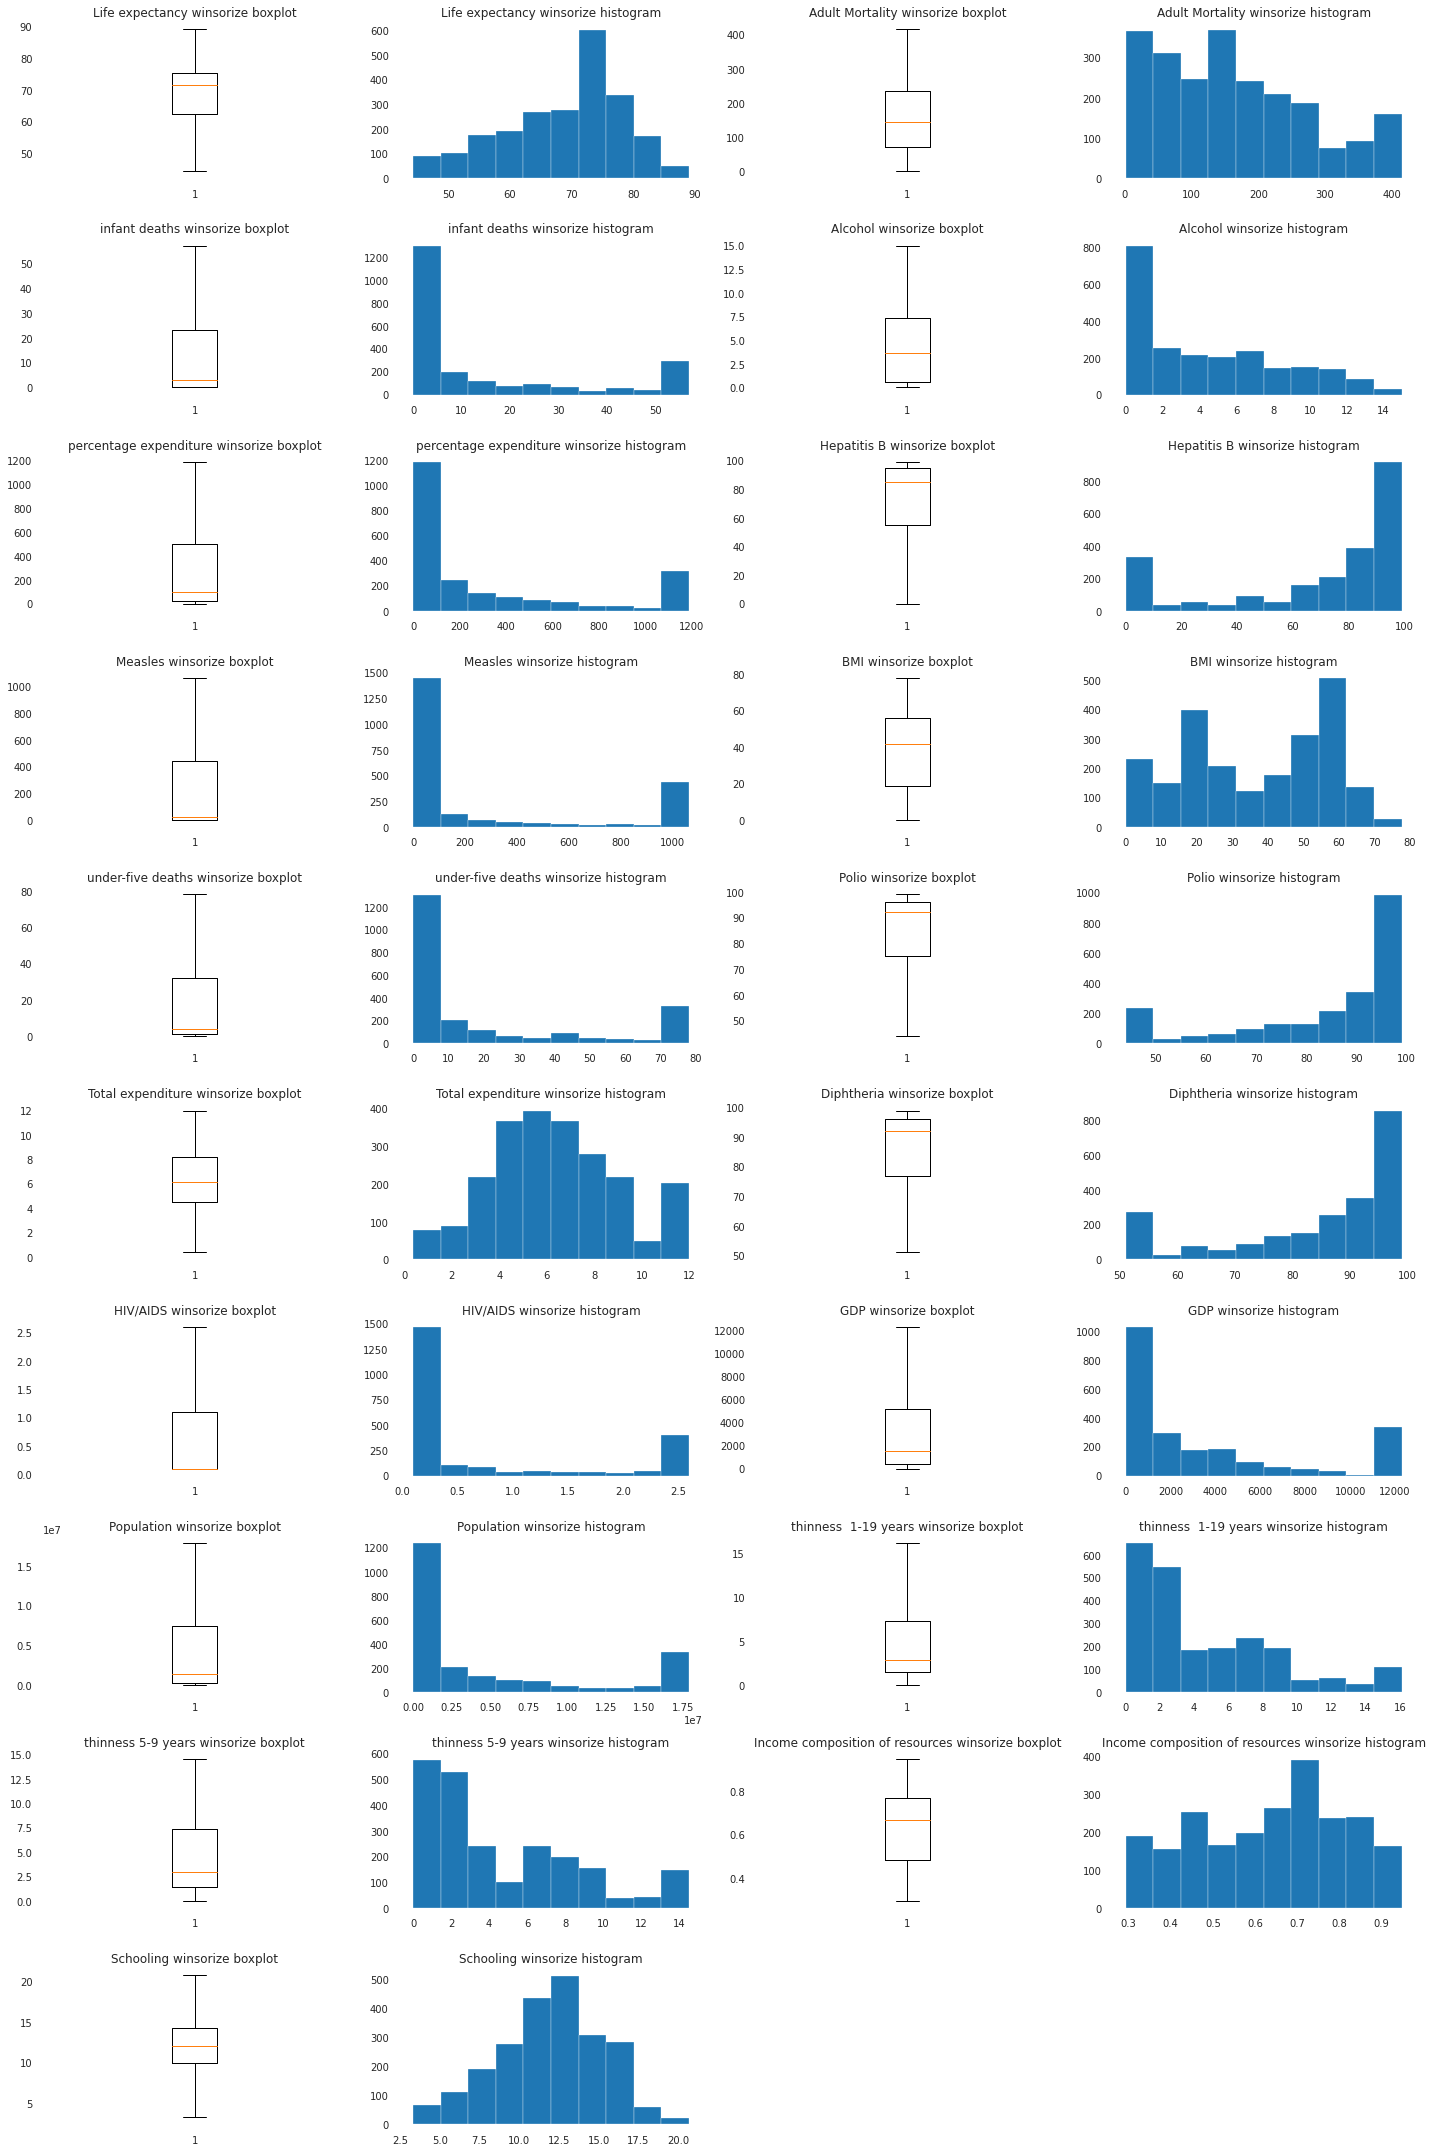

In [18]:
plt.figure(figsize=(20, 30))
i = 0
for column in columns:
    i += 1
    plt.subplot(10, 4, i)
    plt.tight_layout()
    plt.boxplot(winsor_life_df[column])
    plt.title('{} winsorize boxplot'.format(column))
    i += 1
    plt.subplot(10, 4, i )
    plt.tight_layout()
    plt.hist(winsor_life_df[column])
    plt.title('{} winsorize histogram'.format(column))
plt.show()

#Exploratory Data Analysis (EDA)

In [19]:
winsor_life_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2262.000000,2.262000e+03,2262.000000,2262.000000,2262.000000,2262.000000
mean,2007.500000,68.757471,164.333333,14.450928,4.406368,323.695988,69.820513,277.451370,37.047171,19.981874,83.589744,6.365628,84.483201,0.727586,3578.296877,4.831177e+06,4.677011,4.646286,0.633206,11.933289
std,4.601285,9.788059,114.222748,19.846180,4.068269,414.685588,32.963271,418.920515,20.118006,27.934943,17.374880,2.693730,15.687755,0.970580,4204.917911,6.367757e+06,4.183934,4.030207,0.178675,3.322679
min,2000.000000,44.300000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,0.370000,51.000000,0.100000,1.681350,3.400000e+01,0.000000,0.000000,0.293000,3.300000
25%,2004.000000,62.300000,72.000000,0.000000,0.530000,22.120565,55.250000,0.000000,18.500000,1.000000,75.000000,4.470000,77.000000,0.100000,434.066665,1.965672e+05,1.400000,1.400000,0.481250,9.900000
50%,2007.500000,71.400000,146.000000,3.000000,3.635000,97.600031,85.000000,18.000000,41.350000,4.000000,92.000000,6.125000,92.000000,0.100000,1519.201780,1.378866e+06,2.800000,3.000000,0.666000,12.100000
75%,2011.000000,75.400000,235.000000,23.000000,7.317500,502.239774,95.000000,441.000000,55.700000,32.000000,96.000000,8.200000,96.000000,1.100000,5183.340546,7.394106e+06,7.300000,7.400000,0.768750,14.300000
max,2015.000000,89.000000,415.000000,57.000000,14.970000,1187.949491,99.000000,1064.000000,77.600000,78.000000,99.000000,11.980000,99.000000,2.600000,12291.466850,1.789956e+07,16.100000,14.500000,0.948000,20.700000


**Variable Distribution**

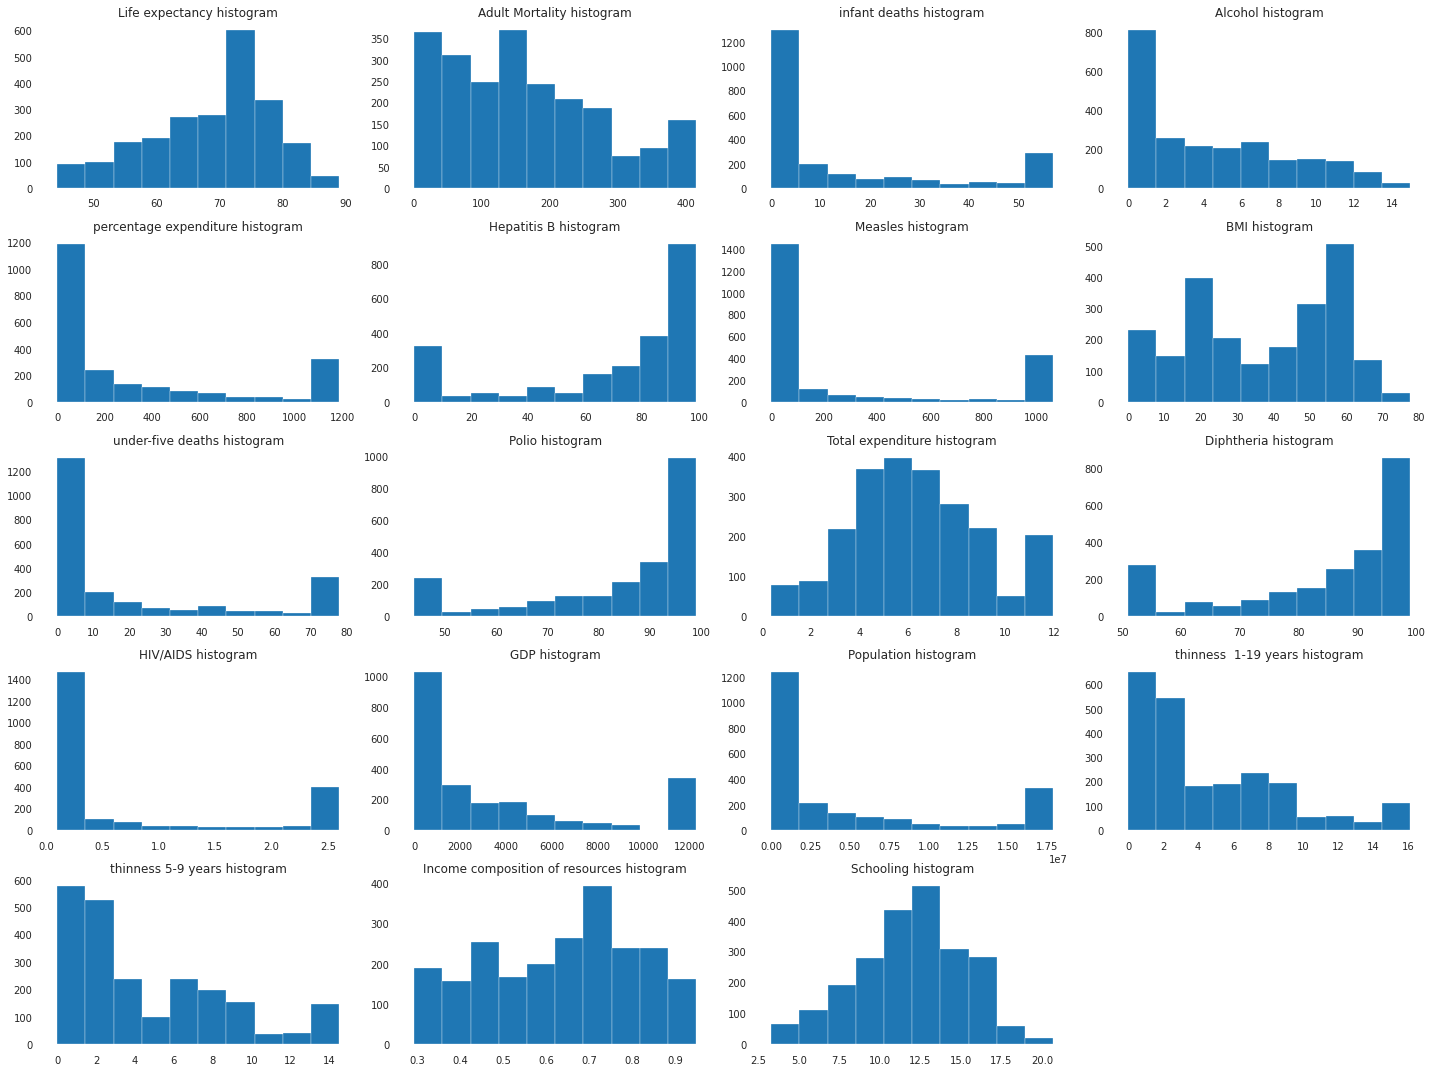

In [20]:
plt.figure(figsize=(20, 15))
i = 0
for column in columns:
    i += 1
    plt.subplot(5, 4, i )
    plt.tight_layout()
    plt.hist(winsor_life_df[column])
    plt.title('{} histogram'.format(column))
plt.show()

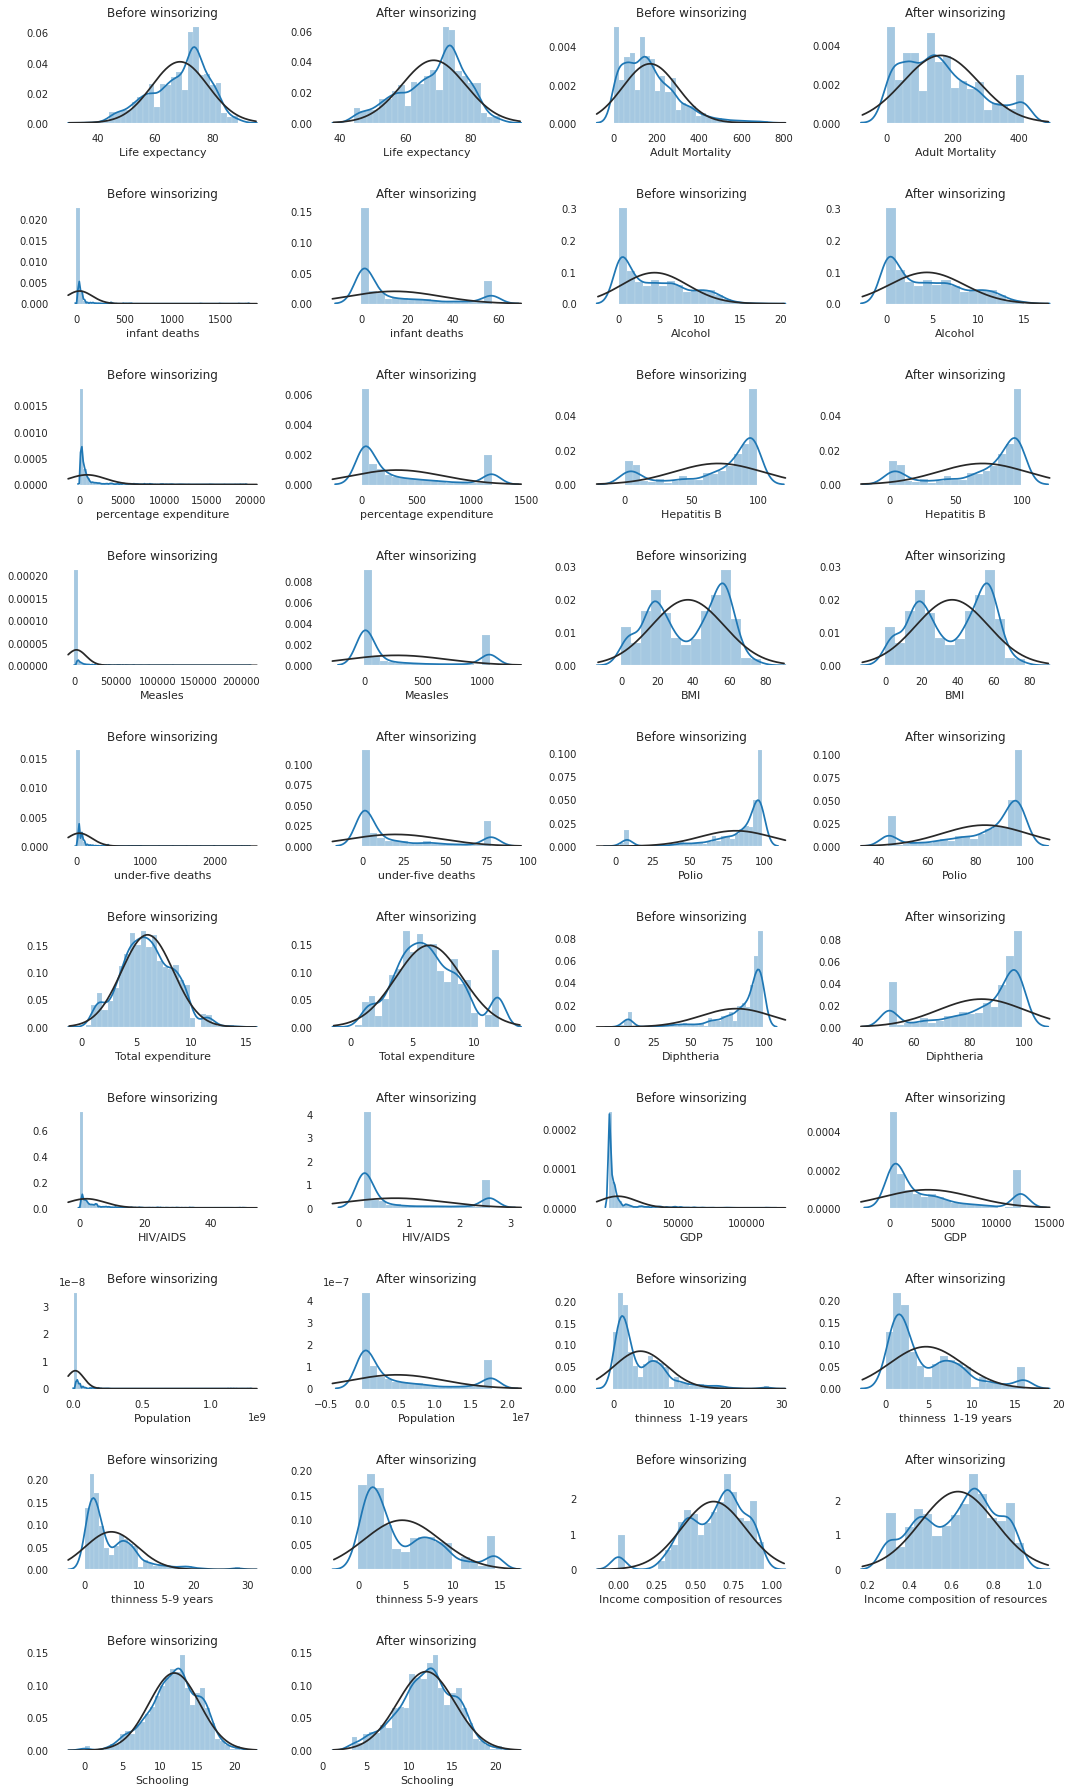

In [21]:
columns = ['Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling']
plt.figure(figsize = (15, 25))
i = 0
for column in columns:
  i += 1
  plt.subplot(10,4,i)
  plt.tight_layout()
  sns.distplot(life_df[column], fit=norm)
  plt.subplots_adjust(hspace= 0.8)
  plt.title('Before winsorizing')
  
  i += 1
  plt.subplot(10,4,i)
  plt.tight_layout()
  sns.distplot(winsor_life_df[column], fit=norm)
  plt.subplots_adjust(hspace= 0.8)
  plt.title('After winsorizing')

**This figure shows how the distribution of every feature changed after applying winsorizing. We see that after winsorizing the outliers of our dataset, every feature became more normal than before.**

**Life expectancy exploration**

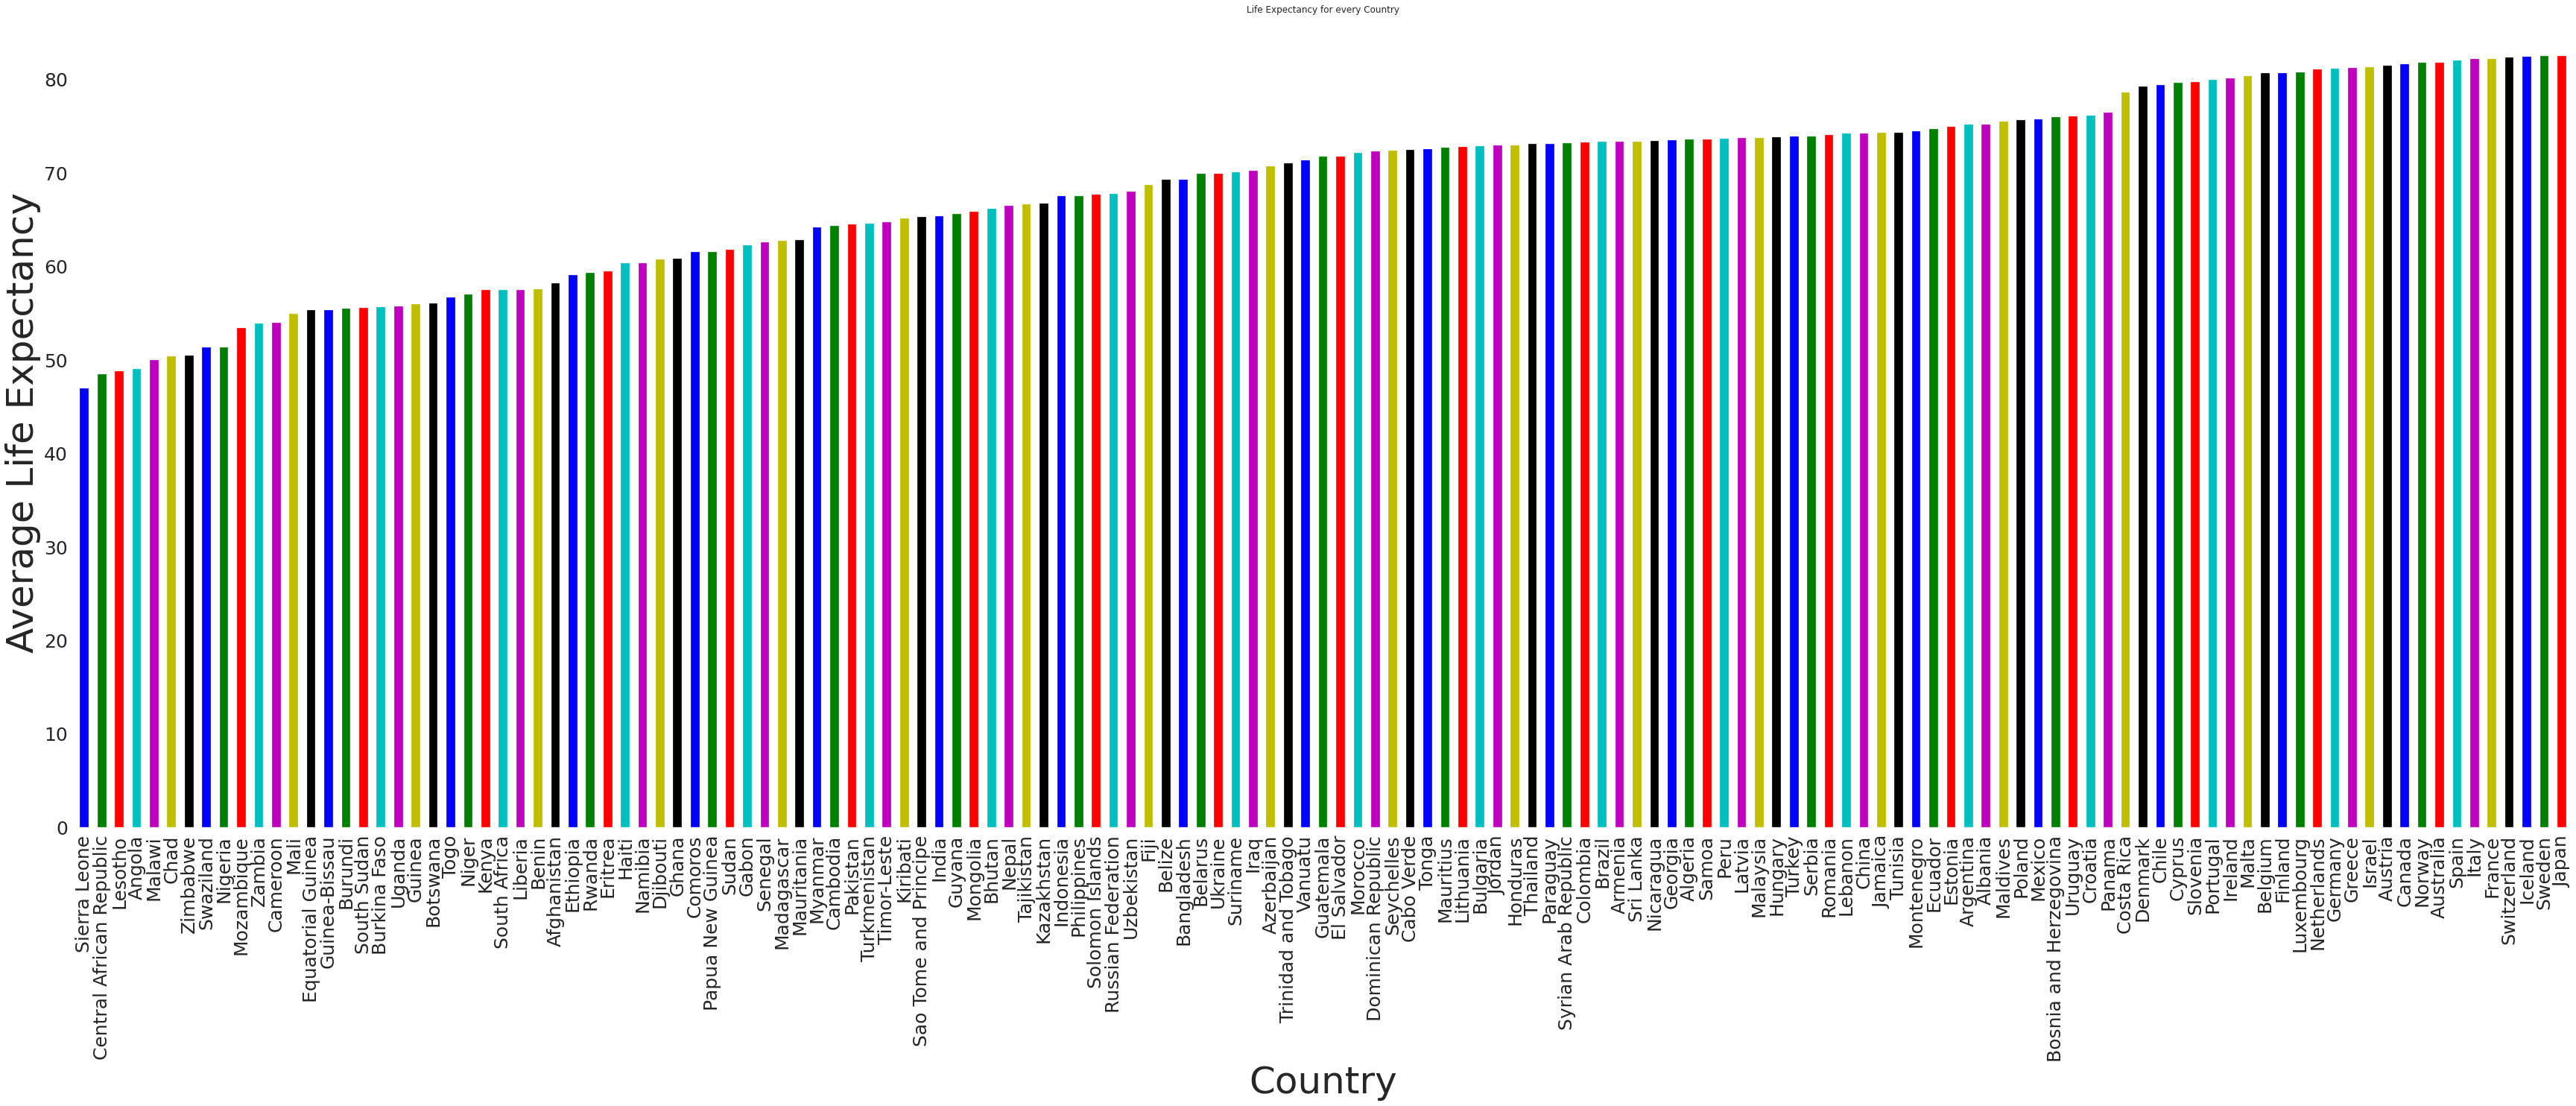

In [22]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
LifeExpCountry = winsor_life_df.groupby('Country')['Life expectancy'].mean().sort_values()
LifeExpCountry.plot(kind='bar', figsize=(60,20), fontsize=25, color = colors )
plt.title('Life Expectancy for every Country')
plt.xlabel('Country',fontsize=50)
plt.ylabel('Average Life Expectancy',fontsize=50)
plt.show()

**Lifespan values have a lot of variance. Patterns are going to be investigated.**

Now lets analyse distributions in two categories **Develeoped** ones and **Developing** ones, let's see if there is any meaningful differences

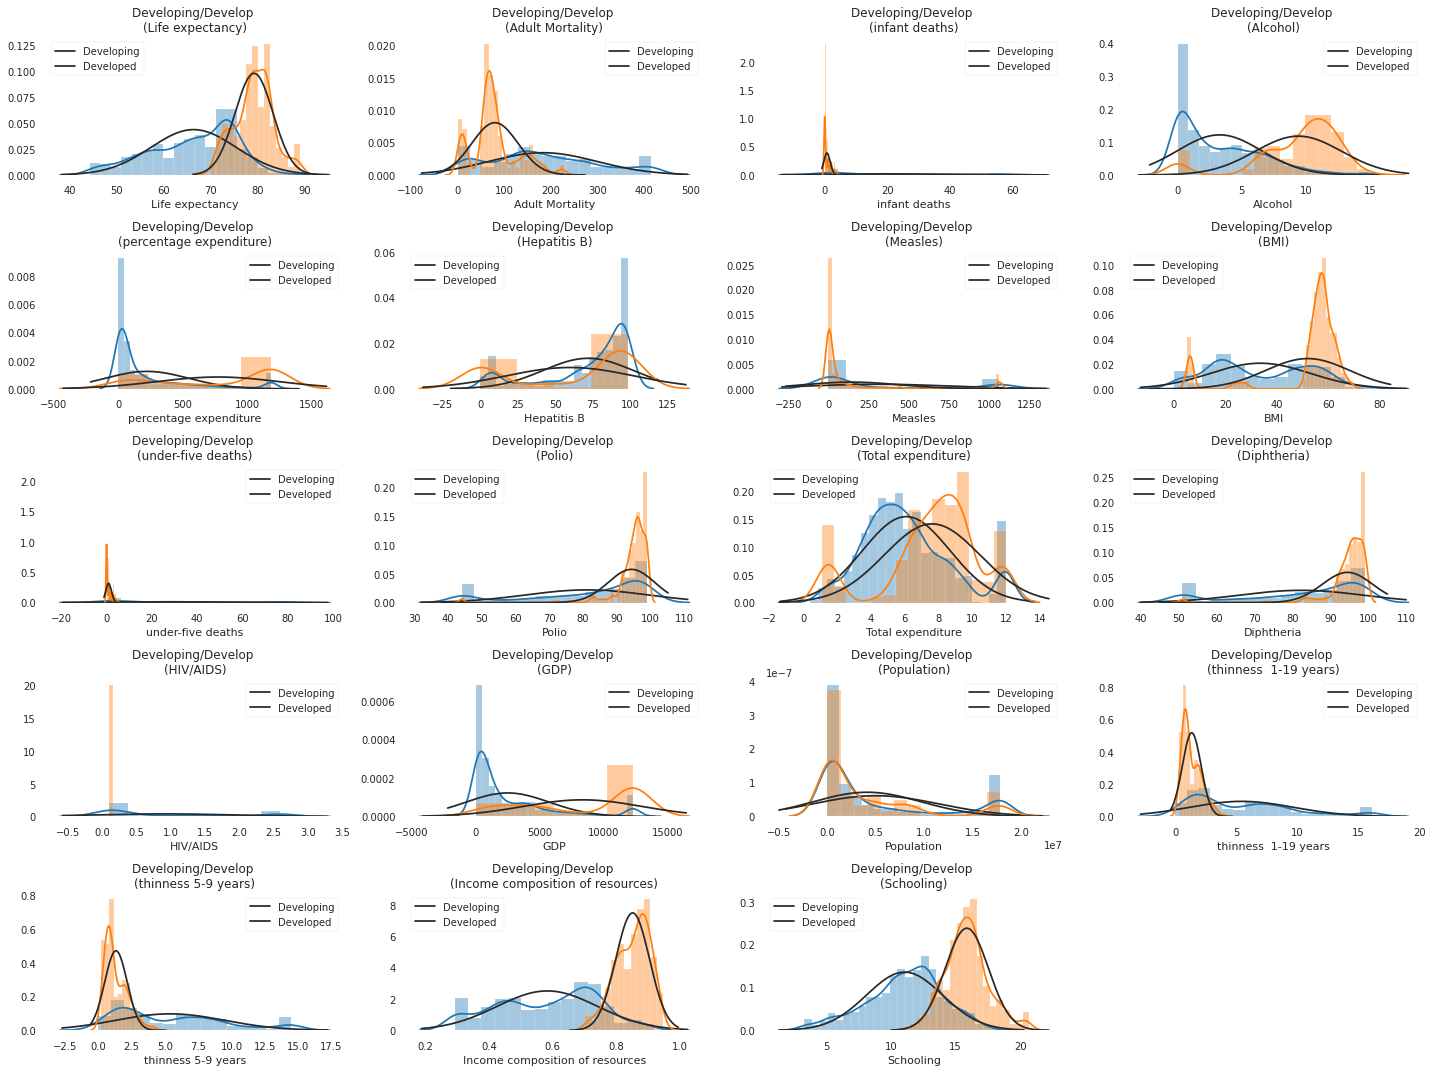

In [23]:
plt.figure(figsize=(20,15))
i = 0
for column in columns:
    i += 1
    plt.subplot(5, 4, i )
    plt.tight_layout()
    sns.distplot(winsor_life_df[winsor_life_df["Status"]=='Developing'][column], fit=norm)
    sns.distplot(winsor_life_df[winsor_life_df["Status"]=='Developed'][column], fit=norm)
    plt.legend(['Developing', 'Developed'])
    plt.title('Developing/Develop \n({})'.format(column))
plt.show()


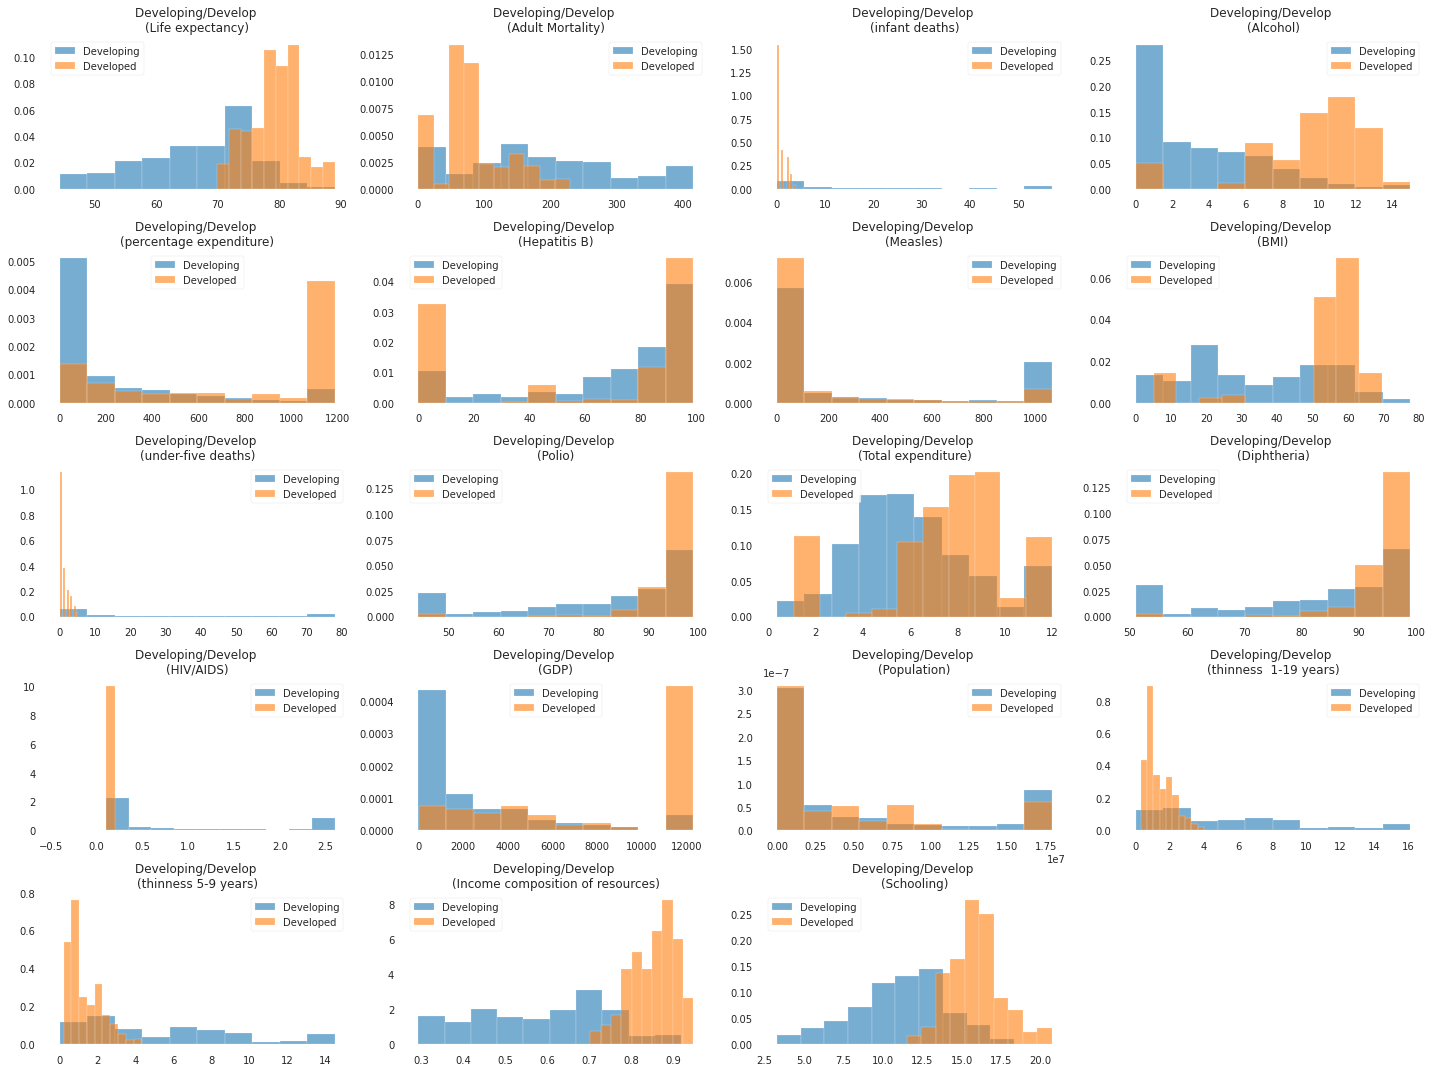

In [24]:
plt.figure(figsize=(20,15))
i = 0
for column in columns:
    i += 1
    plt.subplot(5, 4, i )
    plt.tight_layout()
    plt.hist(winsor_life_df[winsor_life_df["Status"]=='Developing'][column], density=True, alpha=0.6)
    plt.hist(winsor_life_df[winsor_life_df["Status"]=='Developed'][column],  density=True, alpha=0.6)
    plt.legend(['Developing', 'Developed'])
    plt.title('Developing/Develop \n({})'.format(column))
plt.show()



**As expected, some variable distrubutions are different in developed**

Let's see how these variables change in years for both developing and developed ones

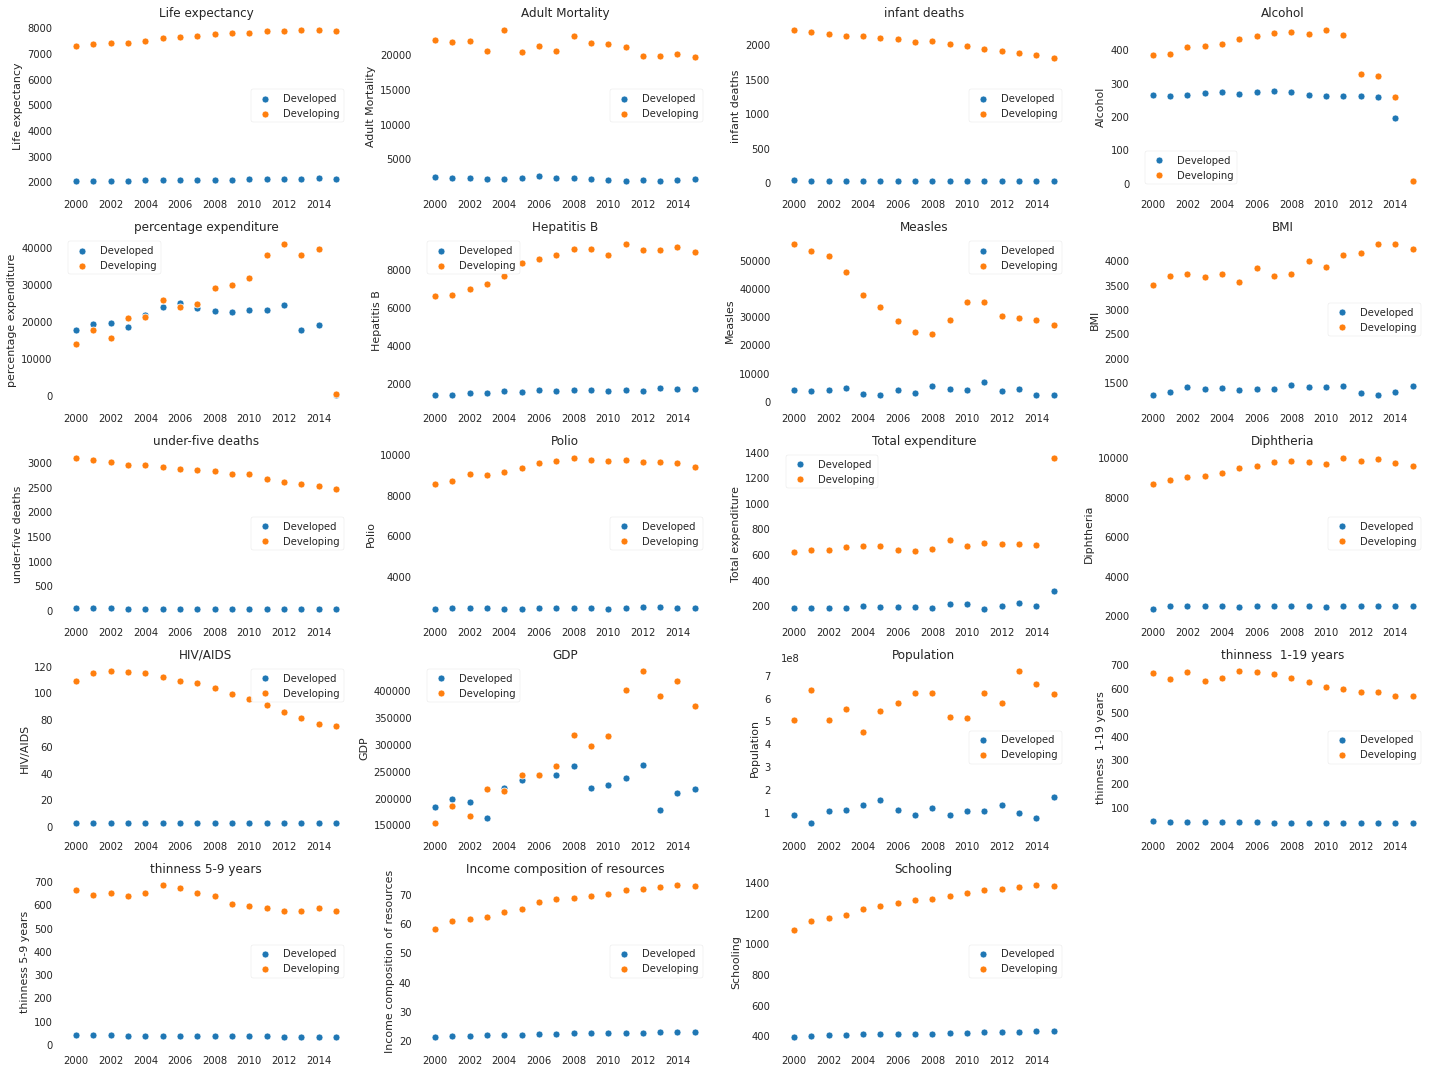

In [25]:
plt.figure(figsize=(20,15))
i = 0
for column in columns:
  i += 1
  plt.subplot(5, 4, i )
  plt.tight_layout()
  sns.scatterplot(winsor_life_df[winsor_life_df['Status'] == 'Developed']['Year'].unique()[::-1], 
             winsor_life_df[winsor_life_df['Status'] == 'Developed'][column].groupby(winsor_life_df['Year']).sum())
  sns.scatterplot(winsor_life_df[winsor_life_df['Status'] == 'Developing']['Year'].unique()[::-1], 
             winsor_life_df[winsor_life_df['Status'] == 'Developing'][column].groupby(winsor_life_df['Year']).sum())
  plt.title(column)
  plt.legend(["Developed", "Developing"])

plt.show()

Some variables change with years. For example, the HIV/AIDS trend decreasing by years.

**Life expectancy for Develeoped ones and Developing ones**

In [0]:
lifeExpStatusYear = pd.DataFrame(life_df.groupby(['Status','Year'])['Life expectancy'].mean())
lifeExpStatusYear.reset_index(inplace = True) 
Developing = lifeExpStatusYear.loc[lifeExpStatusYear['Status'] =='Developing']
Developed = lifeExpStatusYear.loc[lifeExpStatusYear['Status'] =='Developed']


(array([1998., 2000., 2002., 2004., 2006., 2008., 2010., 2012., 2014.,
        2016.]), <a list of 10 Text major ticklabel objects>)

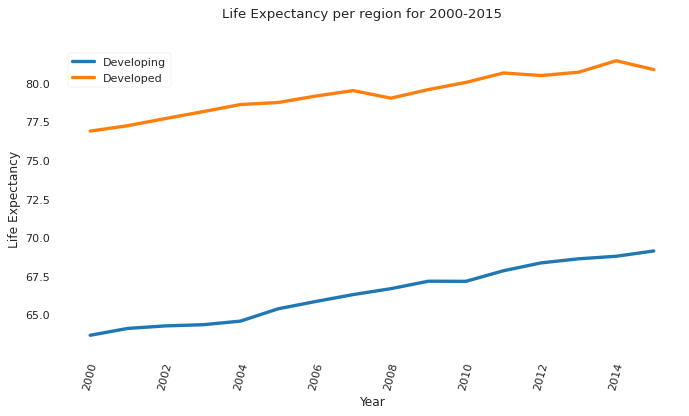

In [27]:
plt.figure(figsize=(10, 5), dpi=80)
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.suptitle('Life Expectancy per region for 2000-2015')
plt.plot(Developing['Year'], Developing['Life expectancy'], label='Developing', linewidth=3)

plt.plot(Developed['Year'], Developed['Life expectancy'], label='Developed', linewidth=3)
plt.legend(['Developing', 'Developed'])
plt.xticks(rotation=75)

In [28]:
Developing = winsor_life_df[winsor_life_df['Status']=='Developing']['Life expectancy'].mean()
Developed = winsor_life_df[winsor_life_df['Status']=='Developed']['Life expectancy'].mean()
Difference = Developed - Developing
print('Average age of Developing countries: {}'.format(Developing))
print('Average age of Developed countries: {}'.format(Developed))
print('Average age difference between Developed and Developing countries: {}'.format(Difference))

Average age of Developing countries: 66.38737811484293
Average age of Developed countries: 79.27475961538457
Average age difference between Developed and Developing countries: 12.887381500541636


**Developing countries has the increase in life expectancy throughout the years, yet it's average lifespan is still almost about 13 years lower than Developed countries.**

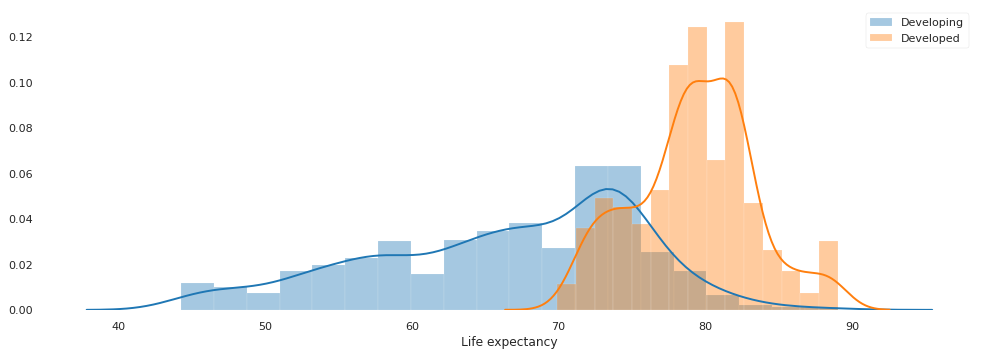

In [29]:
plt.figure(figsize=(15, 5), dpi=80)
sns.distplot(winsor_life_df[winsor_life_df['Status']=='Developing']['Life expectancy'])
sns.distplot(winsor_life_df[winsor_life_df['Status']=='Developed']['Life expectancy'])
labels=['Developed Countries','Developing Countries']
plt.legend(['Developing', 'Developed'])
plt.show()

**A lot of countries considered developing have the same life expectancy with developed countries after the age of 69, as we see in the above figure.**

**Barplots for 'Life expectancy', 'Adult mortality', 'Income', 'Schooling' and 'BMI' for developed and developing countries**

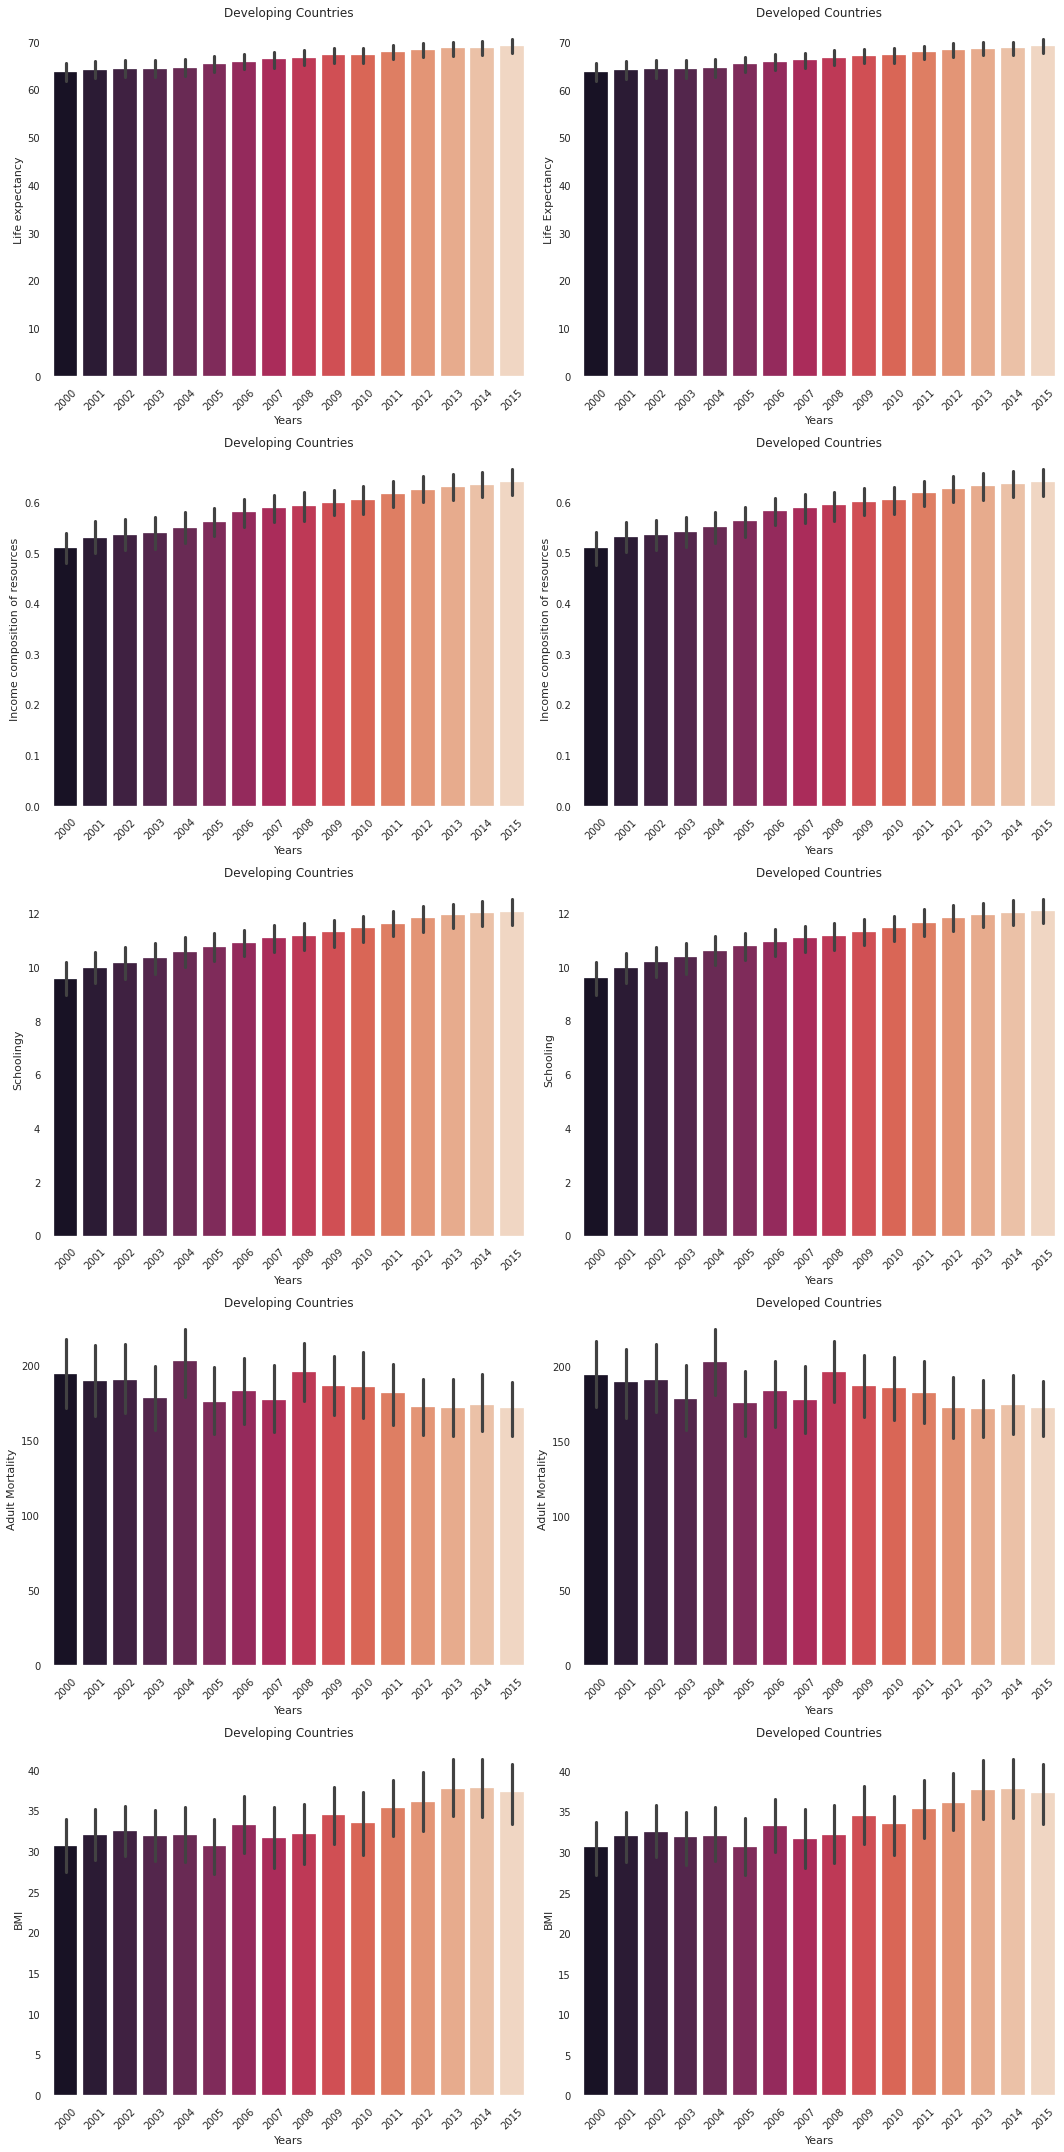

In [30]:
# Life expectancy
plt.figure(figsize=(15,30))
plt.subplot(5, 2, 1)
plt.tight_layout()
plt.tight_layout()
ax1 = sns.barplot(x = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Year'], y = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Life expectancy'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Life expectancy', title='Developing Countries')

plt.subplot(5, 2, 2)
plt.tight_layout()
plt.tight_layout()
ax1 = sns.barplot(x = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Year'], y = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Life expectancy'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Life Expectancy', title='Developed Countries')

# Income composition of resources
plt.subplot(5, 2, 3)
plt.tight_layout()
plt.tight_layout()
ax1 = sns.barplot(x = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Year'], y = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Income composition of resources'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Income composition of resources', title='Developing Countries')

plt.subplot(5, 2, 4)
plt.tight_layout()
plt.tight_layout()
ax1 = sns.barplot(x = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Year'], y = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Income composition of resources'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Income composition of resources', title='Developed Countries')

# Schooling
plt.subplot(5, 2, 5)
plt.tight_layout()
plt.tight_layout()
ax1 = sns.barplot(x = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Year'], y = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Schooling'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Schoolingy', title='Developing Countries')

plt.subplot(5, 2, 6)
plt.tight_layout()
plt.tight_layout()
ax1 = sns.barplot(x = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Year'], y = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Schooling'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Schooling', title='Developed Countries')

# Adult Mortality
plt.subplot(5, 2, 7)
plt.tight_layout()
plt.tight_layout()
ax1 = sns.barplot(x = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Year'], y = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Adult Mortality'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Adult Mortality', title='Developing Countries')

plt.subplot(5, 2, 8)
plt.tight_layout()
plt.tight_layout()
ax1 = sns.barplot(x = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Year'], y = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Adult Mortality'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'Adult Mortality', title='Developed Countries')

# BMI
plt.subplot(5, 2, 9)
plt.tight_layout()
plt.tight_layout()
ax1 = sns.barplot(x = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Year'], y = winsor_life_df[winsor_life_df['Status'] == 'Developing']['BMI'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'BMI', title='Developing Countries')

plt.subplot(5, 2, 10)
plt.tight_layout()
plt.tight_layout()
ax1 = sns.barplot(x = winsor_life_df[winsor_life_df['Status'] == 'Developing']['Year'], y = winsor_life_df[winsor_life_df['Status'] == 'Developing']['BMI'], palette="rocket")
plt.xticks(rotation = 45)
Text = ax1.set(xlabel='Years', ylabel = 'BMI', title='Developed Countries')




**Although 'Life expectancy', Income composition of resources', 'Schooling', 'BMI' by time for both kind of countries, 'Adult mortality' has ups and downs, but over time it is stable**

In [31]:
winsor_life_df['Life expectancy'].groupby(winsor_life_df['Status']).describe()

,count,mean,std,min,25%,50%,75%,max
Status,,,,,,,,
Developed,416.0,79.274760,4.069192,69.9,76.875,79.50,81.9,89.0
Developing,1846.0,66.387378,9.117157,44.3,59.400,67.95,73.5,89.0


**Barplot with the percentage of change of life expectancy (year 2000) to life expectancy (year 2015 ) for every country**

In [0]:
LifeExp2000LifeExp2015 = pd.DataFrame(winsor_life_df.groupby([('Country')], sort=False).apply(lambda x: (x['Life expectancy'].values[0] - x['Life expectancy'].values[-1]) / (x['Life expectancy'].values[0])))
LifeExp2000LifeExp2015.reset_index(level=0, inplace=True)
LifeExp2000LifeExp2015.rename(columns={ LifeExp2000LifeExp2015.columns[1]: 'LifeExpChange'}, inplace = True)

In [0]:
x, y = (list(x) for x in zip(*sorted(zip(LifeExp2000LifeExp2015['LifeExpChange'], LifeExp2000LifeExp2015['Country']), 
                                                          reverse = True)))

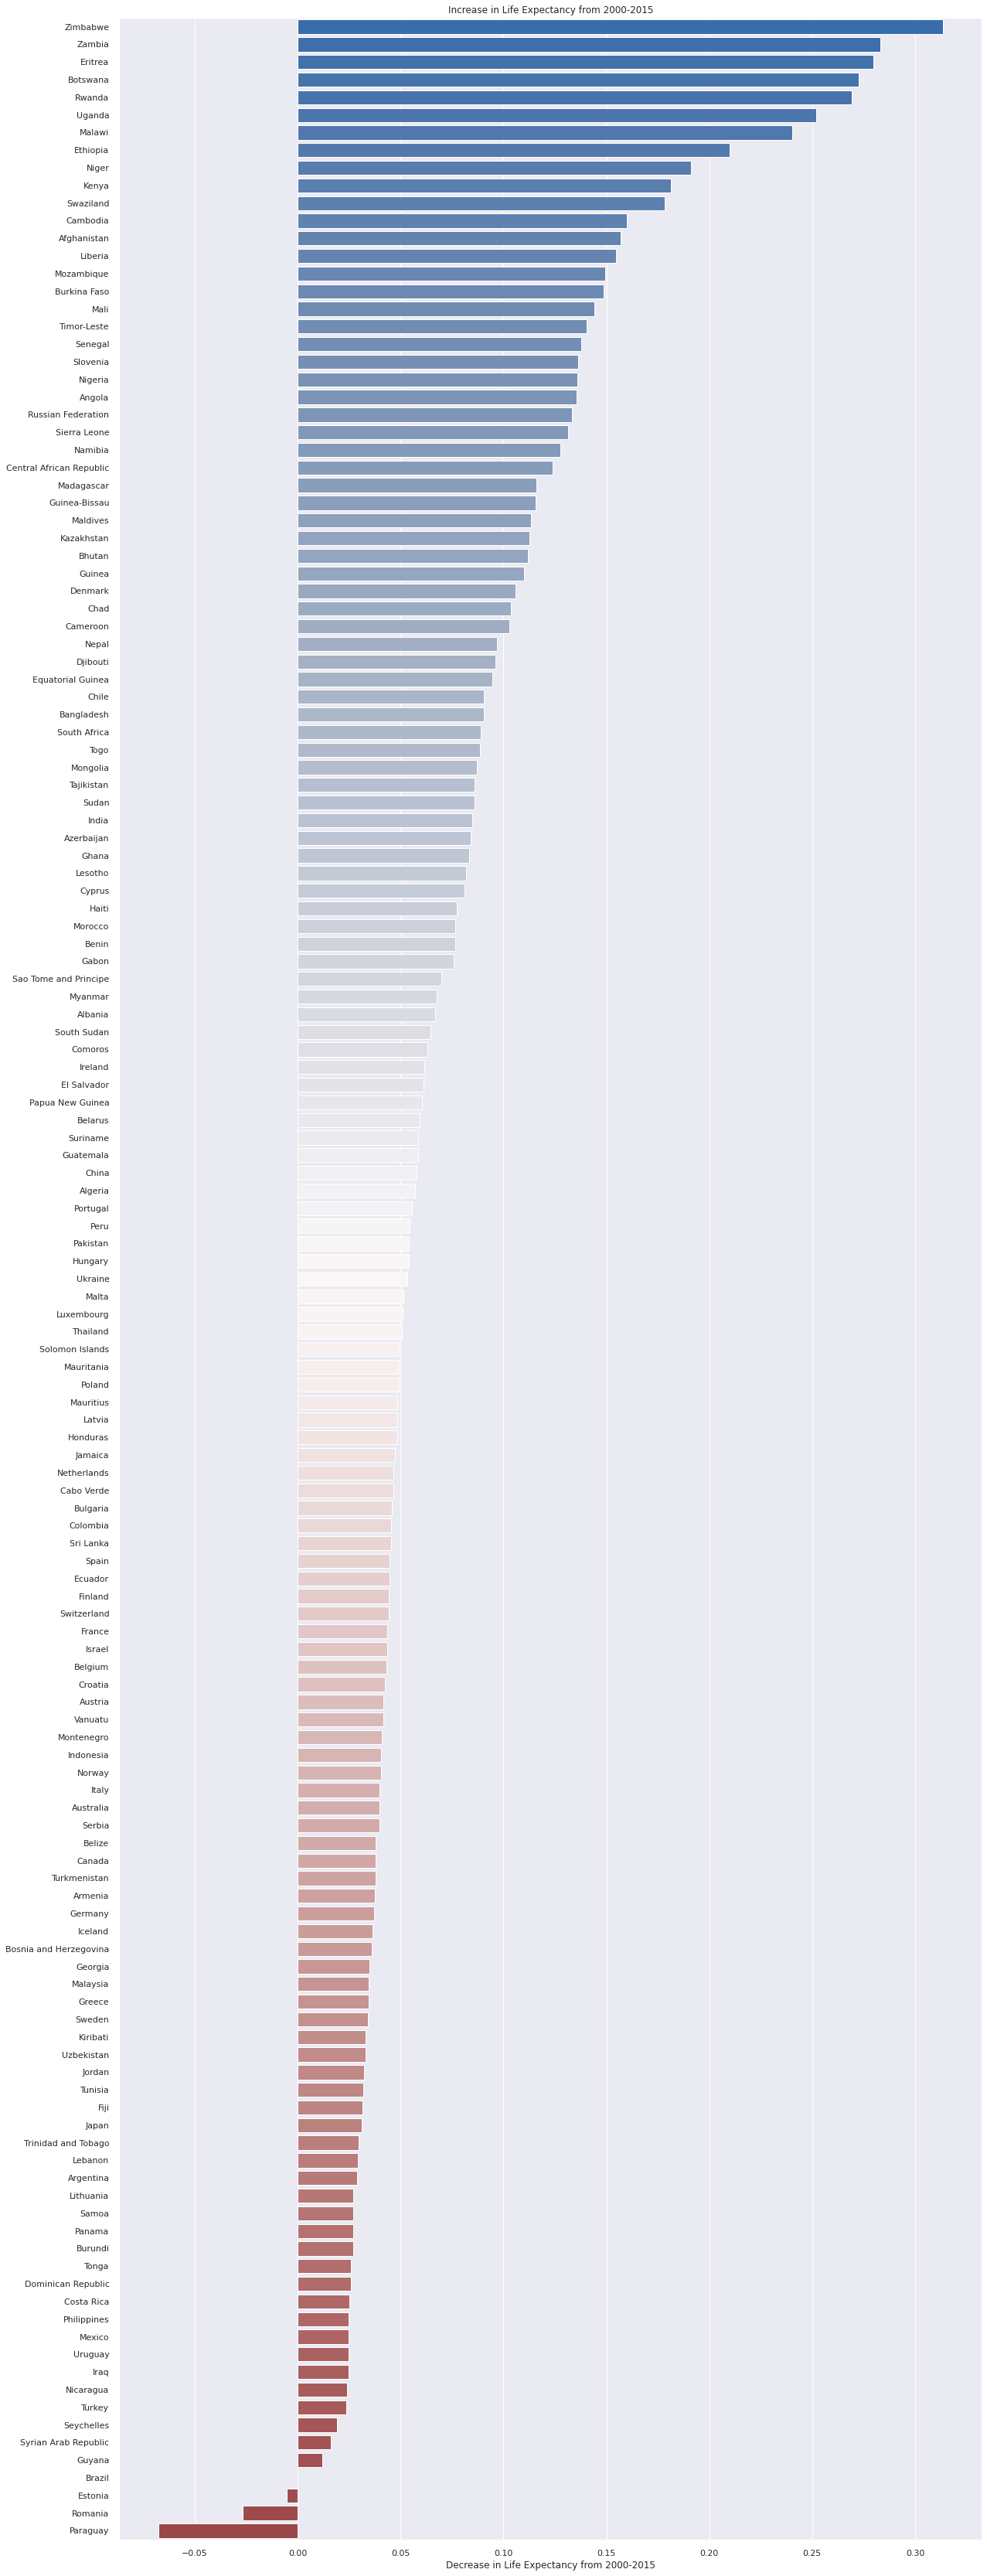

In [34]:
sns.set(font_scale=1) 
f, ax = plt.subplots(figsize=(20, 60))
sns.barplot(x, y, palette="vlag")
Text = ax.set(xlabel='Decrease in Life Expectancy from 2000-2015', 
              title='Increase in Life Expectancy from 2000-2015')

**Most of the countries's life expectancy has increased except for 3.**

**Features's relation with the target variable**

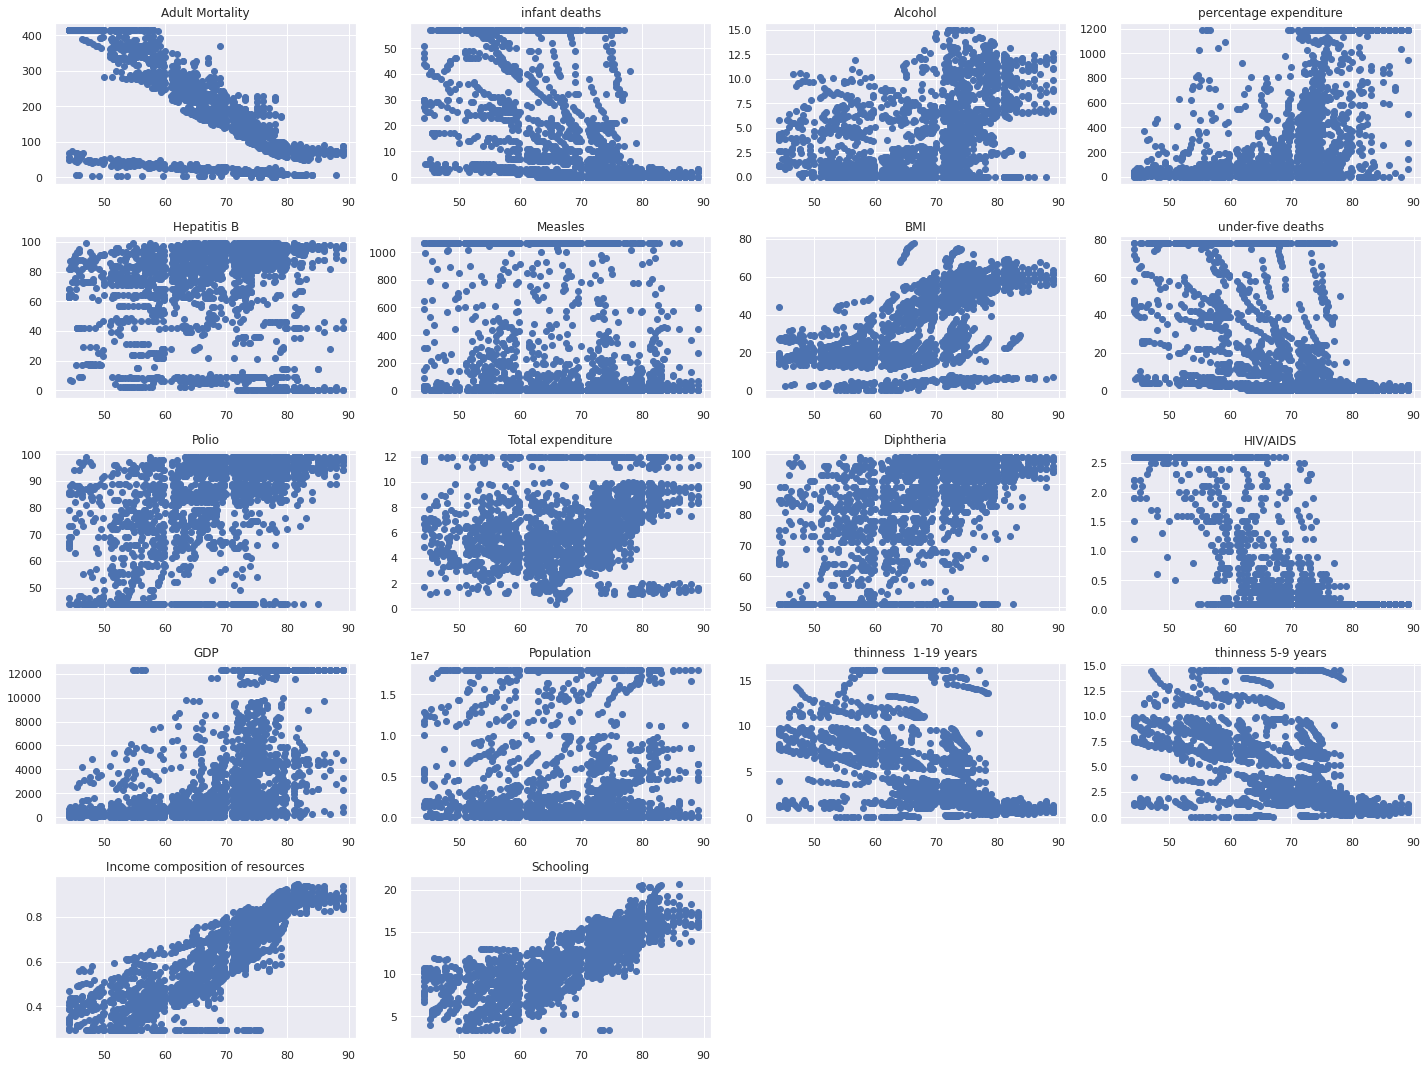

In [35]:
columns = ['Adult Mortality','infant deaths', 'Alcohol', 'percentage expenditure', 
            'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
            'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
            'thinness 5-9 years', 'Income composition of resources', 'Schooling']
plt.figure(figsize = (20, 15))
i = 0
for column in columns:
  i +=1
  plt.tight_layout()
  plt.subplot(5, 4, i)
  plt.scatter(winsor_life_df['Life expectancy'], winsor_life_df[column])
  plt.title(column)

**This scatter plot shows that 'Schooling', 'Income composition of resources' and 'BMI' have a strong positive correlation with Life Expectancy. On the other hand 'Adult Mortality', 'HIV/AIDS' and 'under 5 deaths' have a negative correlation with Life Expectancy**

**Correlation matrix**

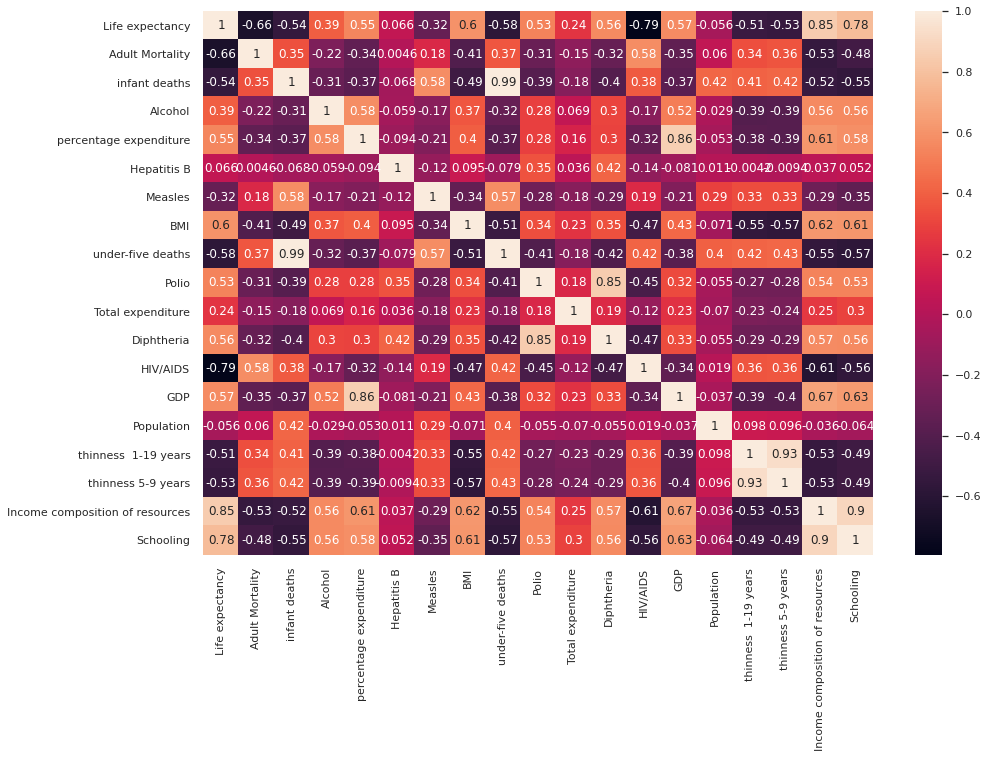

In [36]:
corrl = winsor_life_df.drop(['Country','Year','Status'], axis = 1).corr()
plt.figure(figsize = (15, 10))
sns.heatmap(corrl, annot = True)

**Features with an absolute correlation with target variable > 0.5**

In [37]:
corrlife = abs(corrl['Life expectancy'])
bestfeatures = (corrlife[corrlife>0.5])
bestfeatures = bestfeatures.drop('Life expectancy')
bestfeatures.sort_values(ascending=False)

Income composition of resources    0.847273
HIV/AIDS                           0.792289
Schooling                          0.779569
Adult Mortality                    0.664720
BMI                                0.598242
under-five deaths                  0.576939
GDP                                0.567253
Diphtheria                         0.561274
percentage expenditure             0.545089
infant deaths                      0.544259
Polio                              0.533232
thinness 5-9 years                 0.528258
thinness  1-19 years               0.513636
Name: Life expectancy, dtype: float64

**Feature selection will take place based on the correlation of every feature of the dataset with life expectancy. Given this assumption the top 7 features of the above table will be selected.**

Further 'Income composition of resources', 'HIV/AIDS', 'Schooling', 'Adult Mortality' ,'BMI' ,'GDP' ,'under-five deaths'.

**Correlation matrix between the top 7 correlated features to the target variable**

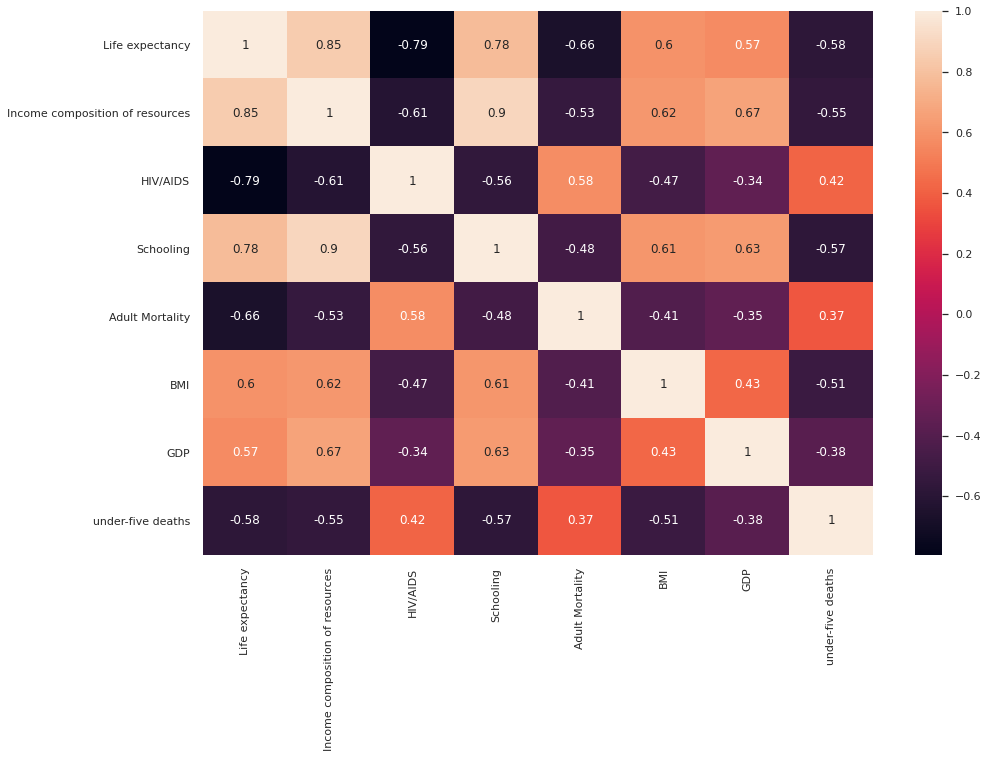

In [38]:
corrl = winsor_life_df[['Life expectancy','Income composition of resources','HIV/AIDS','Schooling','Adult Mortality','BMI','GDP','under-five deaths']].corr()
plt.figure(figsize = (15, 10))
sns.heatmap(corrl, annot = True)

In [39]:
corrlife = (corrl['Life expectancy'])
bestfeatures = (corrlife[corrlife>0.5])
bestfeatures = bestfeatures.drop('Life expectancy')
bestfeatures.sort_values(ascending=False)

Income composition of resources    0.847273
Schooling                          0.779569
BMI                                0.598242
GDP                                0.567253
Name: Life expectancy, dtype: float64

**Lets find out these correlations are statistically significant?**

**These correlations are statistically significant?**


T-Test

In [40]:
x1 = stats.ttest_ind(winsor_life_df['Life expectancy'],winsor_life_df['Schooling'])
x2 = stats.ttest_ind(winsor_life_df['Life expectancy'],winsor_life_df['Adult Mortality'])
x3 = stats.ttest_ind(winsor_life_df['Life expectancy'],winsor_life_df['Income composition of resources'])
x4 = stats.ttest_ind(winsor_life_df['Life expectancy'],winsor_life_df['GDP'])
x5 = stats.ttest_ind(winsor_life_df['Life expectancy'],winsor_life_df['BMI'])
x6 = stats.ttest_ind(winsor_life_df['Life expectancy'],winsor_life_df['HIV/AIDS'])
x7 = stats.ttest_ind(winsor_life_df['GDP'],winsor_life_df['Schooling'])
x8 = stats.ttest_ind(winsor_life_df['Income composition of resources'],winsor_life_df['Schooling'])


a1 = ['x1','x2','x3','x4','x5','x6','x7','x8']
a2 = [x1,x2,x3,x4,x5,x6,x8,x8]
for i in range(0,8):
    print('For {}: {}'.format(a1[i], a2[i]))

For x1: Ttest_indResult(statistic=261.456691495066, pvalue=0.0)
For x2: Ttest_indResult(statistic=-39.65091193312181, pvalue=2.369963908239258e-295)
For x3: Ttest_indResult(statistic=330.96281771382905, pvalue=0.0)
For x4: Ttest_indResult(statistic=-39.69517536576591, pvalue=6.436453339290764e-296)
For x5: Ttest_indResult(statistic=67.41043854931637, pvalue=0.0)
For x6: Ttest_indResult(statistic=328.94611548806023, pvalue=0.0)
For x7: Ttest_indResult(statistic=-161.51487131433714, pvalue=0.0)
For x8: Ttest_indResult(statistic=-161.51487131433714, pvalue=0.0)


**t-test shows us these are all statistacally significant, p-value is lower than 0.05**

In [41]:
import scipy.stats as stats
stats.ttest_ind(winsor_life_df.loc[winsor_life_df['Status']=='Developed','Life expectancy'],
                winsor_life_df.loc[winsor_life_df['Status']=='Developing','Life expectancy'])

Ttest_indResult(statistic=28.200666891665517, pvalue=3.563117051142122e-150)

**PCA (Principal Component Analysis)**

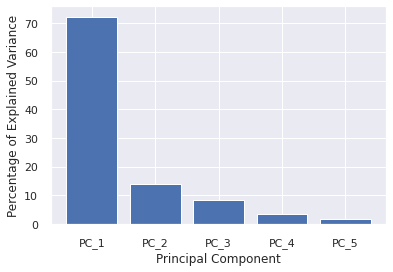

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [72.24930516 14.04760851  8.40386323  3.58100136  1.71822174]


In [74]:
data = winsor_life_df[['Life expectancy','Income composition of resources','Schooling','Adult Mortality','GDP']]

data = StandardScaler().fit_transform(data)
pca = PCA()
data = pca.fit_transform(data)


per_var = pca.explained_variance_ratio_*100

labels = ['PC_' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.show()

print('The percentage of total variance in the dataset explained by each','component from Sklearn PCA.\n', per_var)

More than 72% of the total variance is explained by the first principal component.

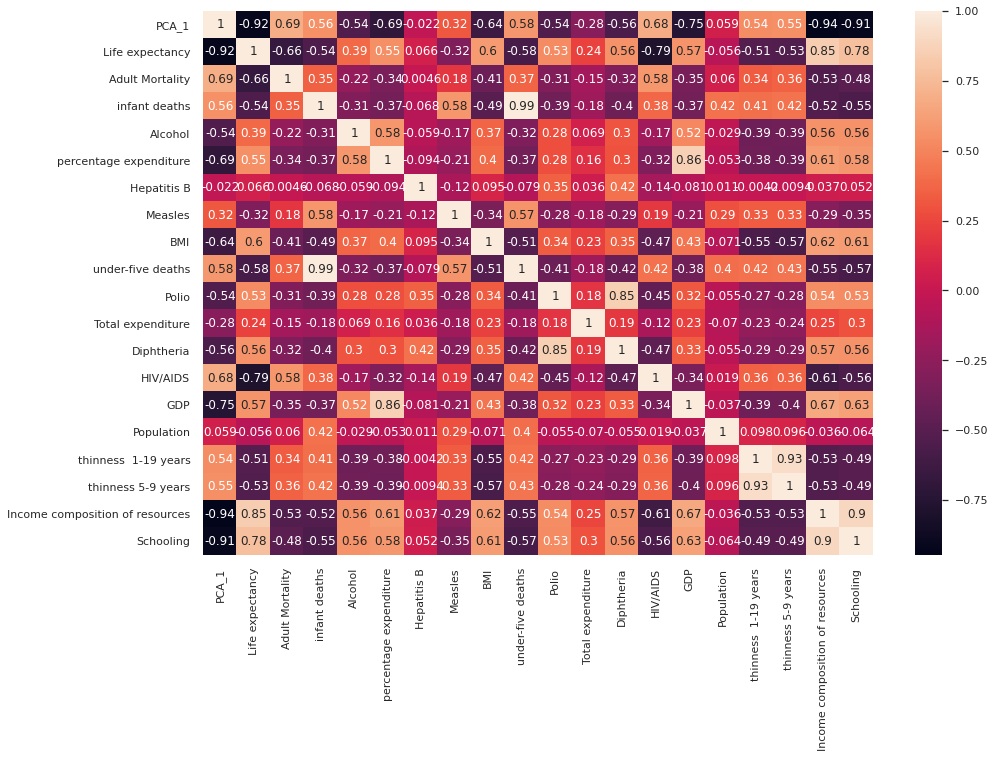

In [77]:
corrl = winsor_life_df[['PCA_1', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling',]].corr()
plt.figure(figsize = (15, 10))
sns.heatmap(corrl, annot = True)

#Results
**As we showed our analyses and graphs, Life Expectancy is higher in developed countries**
**Life expectancy also have a correlation with the Income composition of resources, HIV_AIDS,  and education.**
**It is meaningful that where the adult mortality is higher, Life Expectancy is lower.**
**We could not find any relation between GDP or Total Expenditure**

#Conclusions
**Since we have lots of missing (NaN) value in our raw data, we may have lost critical ones having correlations with each other. The most accurate approach will be filling those population and GDP values with the exact values that can be found on the internet. Even so, we can easily say that education is a must!**

**Mental Health and Life Expectancy Correlation also seems essential to look further this study!**